# INFO 6106 - Neural Modeling: Final Project
# Lake Snow Effect using RNN and CNN models
**Submitted by:**
- Aditi Krishna
- Abhishek Shankar

This Notebook consists of the first method which we applied to try fitting the LES dataset along with the 1D and 2D images  which were presented to us. In this method we created new features and used the 1D images to calculate intensities on the the days and different times. The 2D images were used as part of the **Convolutional Neural Network (CNN)** whereas the numerical data was used in a **Recurrent Neural Network (RNN)**, both networks were **concatenated to predict occurence of snowfall**.

Our Intuitions for building the models in different methodologies is elaborated in this notebook

## Importing libraries.

In [1]:
#Time the entire notebook
import timeit
start_time = timeit.default_timer()

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
from keras import backend as K
import matplotlib as plt
import ast
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import preprocessing
from PIL import Image, ImageOps
from keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Dense
from tensorflow.keras.models import Model

#Ensuring the directories are correct
DATA_dir = os.getcwd() +"\\DATA\\"
photo_dir = os.getcwd() +"\\DATA\\testing_img\\"
new_photo_dir = os.getcwd() +"\\DATA\\new_testing_img\\"

#Version Check
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.11.0


## Functions 

<font color='red'>The Explanation for each function is given below</font>

1. save_pic - Saving Pictures to the working directory given a numpy array and file namme

In [2]:
def save_pic(arr, filename):
    # Plot the image
    plt.imshow(arr, cmap='gray')
    plt.axis('off')
    new_photo_dir = os.getcwd() +"\\DATA\\new_testing_img\\"
    # Save the image as PNG
    plt.savefig(new_photo_dir+filename, bbox_inches='tight', pad_inches=0)

2. pad_images - Padding Images along the required axis

In [3]:
def pad_images(arr):
    if arr.shape[1]==78:
        arr1 = np.zeros((105,))
        arr2 = arr
        arr1_reshaped = arr1.reshape((105, 1, 1))
        result = np.concatenate((arr2, arr1_reshaped), axis=1)
    else:
        # print("Padding Not Required")
        result = arr
    return result

3. clean_arrays - Ensuring arrays are the right shape and not of length one

In [4]:
def clean_arrays(validate):
    validate['Elements'] = validate.iloc[:,0].apply(lambda x : np.array(x).shape[0] if len(np.array(x)) > 1 else None)
    validate['Rows'] = validate.iloc[:,0].apply(lambda x : np.array(x).shape[1] if len(np.array(x)) > 1 else None)
    validate = validate[[x for x in validate.columns if x not in ['Elements','Rows']]]
    return validate   

4. avg_intensity - Calculate intensity of clouds over the lake using the 1 Dimension data


In [5]:
def avg_intensity(b):
    b['Avg_Intensity'] = b['Lake_data_1D'].apply(lambda x : np.mean(eval(x.replace('nan','0'))))
    b = b[[x for x in b.columns if x not in ['File_name_for_1D_lake','File_name_for_2D_lake', 'Lake_data_1D', 'Lake_data_1D_array']]]    
    b['Avg_Intensity_Rounded'] = round(b['Avg_Intensity'],2)
    return b    

5. preprocessing - Ensure the LES dataset is suitable for the Neural Network

- 14:00 to 21:00 CST - Light is most visible at that point of time
- Feature Engineering
- Check the 2D numpy array of the Lake

In [6]:
def preprocessing(dataset):
    a = dataset
    #Calculate the average intensity of the image
    a = avg_intensity(a)    
    
    a.iloc[:,1] = pd.to_datetime(a.iloc[:,1],format= '%H:%M' ).dt.time
    cond1 = ((a.iloc[:,1] >= pd.to_datetime("14:00",format= '%H:%M').time())  & (a.iloc[:,1] <= pd.to_datetime("21:00",format= '%H:%M').time()))
    a = a[cond1]
    a = a[[x for x in a.columns if (('utc' not in x.lower()))]]
    
    #Convert columns to numeric
    for cols in a.iloc[:,2:].columns:
        if cols=='Lake_data_2D':
            pass
        else:
            a[cols] = pd.to_numeric(a[cols], errors = 'coerce')
    
    a = a.dropna(axis=1, how='all')
    
    a = a[[x for x in a.columns if x not in ['File_name_for_1D_lake','File_name_for_2D_lake', 'Lake_data_1D']]]
    
    df = a.copy()
    df['Temp (F)'] = df.groupby(['Date_CST'])['Temp (F)'].transform('mean') 
    df["Snowfall"] = 0    
    
    # Point 1    
    df['Temp_Humidity_F'] = df['Temp (F)'] *    df['RH (%)']/100
    df['Temp (C)'] = (df['Temp (F)'] - 32) * 5/9    
    df['Temp_Humidity_C'] = df['Temp (C)'] *    df['RH (%)']/100
    df['Temp_Humidity_C_Mean'] = df['Temp_Humidity_C'].groupby(df['Date_CST']).transform('mean')
    # High values indicates greater snowfall 
    # Point 2
    df['Temp_diff'] = (df['Dewpt (F)'] - df['Temp (F)'])
    # if almost same then condenation happens
    #Point 3
    df['Pressure_diff'] = df['Atm Press (hPa)'] - df['Sea Lev Press (hPa)']
    #Negative temp indciates snowfall
    #Point 4
    df['Cloud Ceiling (ft)'] = df['Low Cloud Ht (ft)'].fillna(0) + df['Med Cloud Ht (ft)'].fillna(0) + df['High Cloud Ht (ft)'].fillna(0)
    #CC is low and atmp_pressure is high - Stable atmosphere and no snowwfall at all 
    #CC is high and Humidity is high Sowfall possible
    
    #Point 5
    df['Visibility (m)'] = df['Visibility (mi)'] * 1609.344
    #snow can occur with visibility as low as 1/4 mile (or 402 meters)
    #Lets take the days the mean of the days data for each datapoint
    df['Mean_Cloud_Height'] = df['Cloud Ceiling (ft)'].groupby(df['Date_CST']).transform('mean')
    df['Mean_RH'] = df['RH (%)'].groupby(df['Date_CST']).transform('mean')

    #Final Condition
    cond1 = (( df['Temp_Humidity_C'] > df['Temp_Humidity_C_Mean']) | \
             ((df['Cloud Ceiling (ft)'] > df['Mean_Cloud_Height']) & (df['RH (%)'] > df['Mean_RH'])) | \
             (df['Pressure_diff'] < 0) & \
              ((df["Temp (F)"] <= 32) & \
             (df["Precip (in)"] > 0) & (df['Avg_Intensity'] >= 0.25)))  
    df['Snowfall'] = np.where(cond1,1,0)
    
    
    d1 = df[['Lake_data_2D','Snowfall','Date_CST', 'Time_CST']]
    d2 = df[[x for x in df.columns if x not in ['Lake_data_2D','Snowfall']]]   

    d1.iloc[:,0] = d1.iloc[:,0].apply(lambda x : eval(x.replace("array(","").replace(")","").replace('nan',"0")))
    d1['Check'] = d1.iloc[:,0].apply(lambda x : 0 if len(x) > 1 else 1)

    
    d1 = d1[d1['Check']==0]    
    
    rows = round(d1.iloc[:,0].apply(lambda x : np.array(x).shape[0]).mean())
    elements = round(d1.iloc[:,0].apply(lambda x : np.array(x).shape[1]).mean())
    try:
        #d1.iloc[:,0] = d1.iloc[:,0].apply(lambda x : np.array(x).reshape((rows,elements,1)) if len(x) > 1 else None)    
        print("################ DONE "+ str(vals) + " ############")
    except:
        print("Please check the following year "+ str(vals))     

    return d1,d2        

6. model_metrics - Plot the loss and accuracy of the model on matplotlib

In [7]:
def model_metrics(history):

    try:
        # Plot the training and validation loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()
    except:
        print("Error no Loss")
    try:    
        # Plot the training and validation accuracy
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')
        plt.show()    
    except:
        print("Error No Accuracy")

7. plot_pic - Visualise our clouds given a numpy array

In [8]:
def plot_pic(arr):
    plt.imshow(arr, cmap='gray')
    plt.show()

8. save_dict - Save our data as a pickle
9. load_dict - Load our data to the IDE

In [9]:
def save_dict(data,name):
    #Add the data and the name of the file - gets saved to the current working directory
    pickle_out = open(name+'.pickle', 'wb')
    pickle.dump(data, pickle_out)
    pickle_out.close()

def load_dict(name):
    pickle_in = open(name+'.pickle', 'rb')
    new_dict = pickle.load(pickle_in)
    return new_dict

10. Precision, recall, f1 - Function to validate mertics used by the keras library to calculate metrics

In [10]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

12. shift_data - Create a sliding window using the Pandas shift API over the required period of time

In [11]:
def shift_data(df,timestep):
    i = timestep
    print("Predicting for ",i," hours :")
    df2 = df.copy()
    df2['LESShift'+str(i)] = df2['Snowfall'].shift(-i)
    df2 = df2[0:-i]    
    return df2

13. arrays_2_png - Professors function to visualise the clouds given the various parameters

In [12]:
def arrays_2_png(lat, lon, val, fig_name):
    status_code = -1
    if len(lat) == len(lon) == len(val):
        plt.figure(figsize=(10, 10))
        plt.scatter(lon, lat, c=val, cmap=cm.gray, marker='s')
        plt.colorbar(orientation='vertical')
        status_code = 0
    else:
        status_code = 255

    return status_code

14. plot_corr - Function plots a graphical correlation matrix for each pair of columns in the dataframe.

In [13]:
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)

## Reading the dataset

The data from each Fall-Winter season is read fromt the indivdual files to ensure that the systems RAM is not overloaded. The data is stored in dictionaries which is later written to a pickle file. This helped us work with each year induvidually or all years togther

## Feature Engineering & Preprocessing

**We know that the dataset is very imbalanced hence one of the methods we tried was to engineer new columns using the existing dataset. The dataset was improved with the assumptio**

### Further analysis of columns to form features
 
**These features can be used to come up with a condition to optimise the label**

    1. RH% - Relative Humidity %
    
     High relative humidity levels can lead to the formation of low-level clouds such as stratus and fog, while lower     relative humidity levels may result in the formation of high-level clouds such as cirrus or no clouds at all.
    
    2. Pressure columns
    
    A positive difference between the atmospheric pressure and the sea level pressure indicates that the atmospheric pressure is higher than the standard pressure at sea level, which means the air is denser and more stable.
    
    3. Using the cloud ceiling temperature
    
    The cloud ceiling feature can provide valuable information for predicting cloud formation and potential for snowfall. By combining the low, medium, and high cloud heights, you get a comprehensive view of the vertical distribution of clouds in the atmosphere. This can be used to identify areas where clouds are likely to persist and produce precipitation.
    
    4. Intensity of Cloud from image data

    a. lets see if the avg of each picture = 1  means there is some cloud with moisture
    b. if avg intensity of each picture is less than 1 there is no cloud with moisture

    In the image data, pixels with close-to-zero intensities represent the absence of clouds, while pixels with intensities close to 1 indicate the presence of moisture-retaining clouds. 
    It is important to distinguish between these two types of pixels when processing and analyzing the data, as they can have significant impacts on the resulting insights and predictions.

### Hence we can come up with the following conditions to help form the labels

**Variable Conditions**

1. Temp_Humidity_C - Hourly humidity must be greater than daily avg humidity 
2. Cloud heights and Relative Humidity - These features must be high
3. Pressures - Negative ppressure diff between sea and atmospheric pressure

**Constant Conditions**
1. Temperature must be < 0&deg;C
2. Precip must be > 0
3. Intensity of images must be > 0

## Converting the conditions required for cloud formation and/or snowfall into python

`cond1 = (( df['Temp_Humidity_C'] > df['Temp_Humidity_C_Mean']) | \
         ((df['Cloud Ceiling (ft)'] > df['Mean_Cloud_Height']) & (df['RH (%)'] > df['Mean_RH'])) | \
         (df['Pressure_diff'] < 0) & \
          ((df["Temp (F)"] <= 32) & \
         (df["Precip (in)"] > 0) & (df['Avg_Intensity'] > 0)))`

**To run the data preperation - Change the boolean to `True`**

For this notebook the datasets have been preprocessed. The data is available in the  working directory.

## Loading the dataset

The preprocessed dataset is loaded from the pickle file to be analysed. The file is actually a dictionary with keys as the years and the values as the weather data associated with that particular year.

`pd.concat(overall.values(), ignore_index=True)` helps convert the `dict` to a `dataframe`

In [14]:
#Ensure the file Input_Dataset is in the directory (check os.getcwd())
overall = load_dict("Input_Dataset")
data1 = pd.concat(overall.values(), ignore_index=True)
print("DATASET LOADED")

DATASET LOADED


**Checking on the balance of the dataset**

<AxesSubplot:>

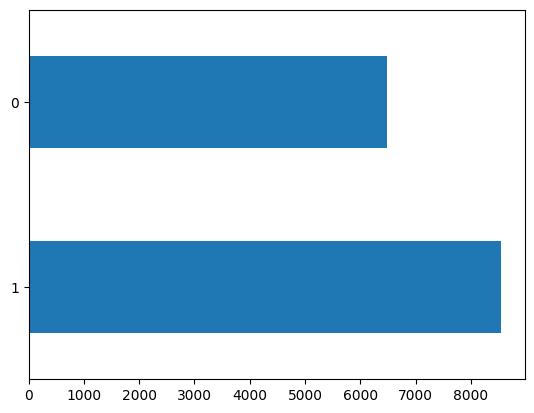

In [15]:
data1['Snowfall'].value_counts().plot(kind='barh')    

### VALIDATING ASSUMPTION ABOUT INTENSITY - ANALYSING THE DATASET WHERE INTENSITY > 0

Visually we are checking if the assumption we made about Heavy cloud presence when intensity > 0. Plotting the ppictures we can see that theere are clouds which are present over the lake

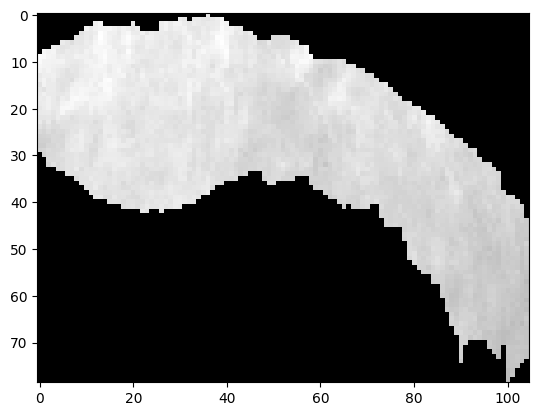

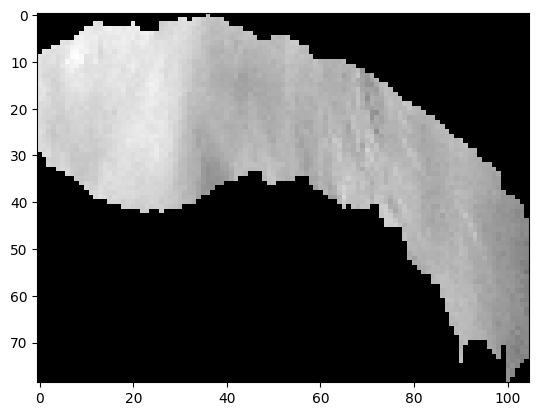

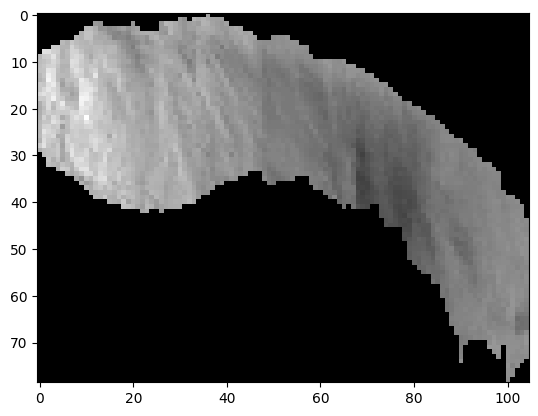

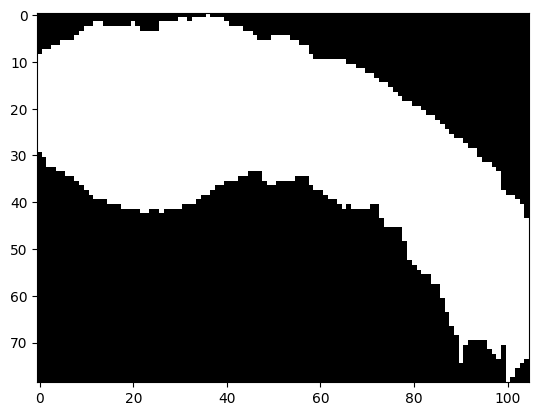

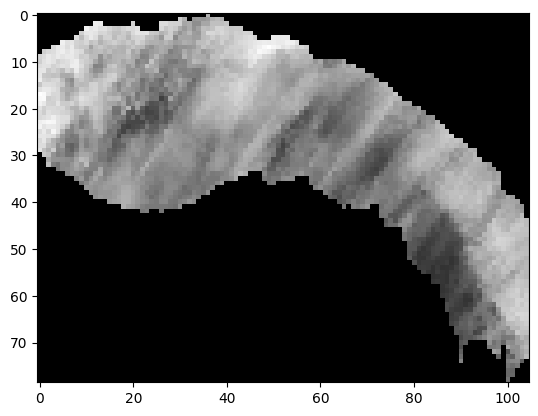

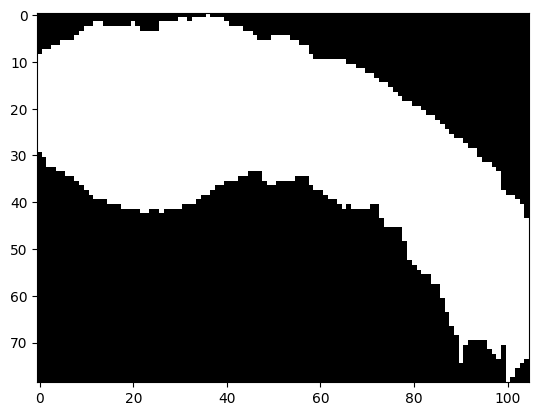

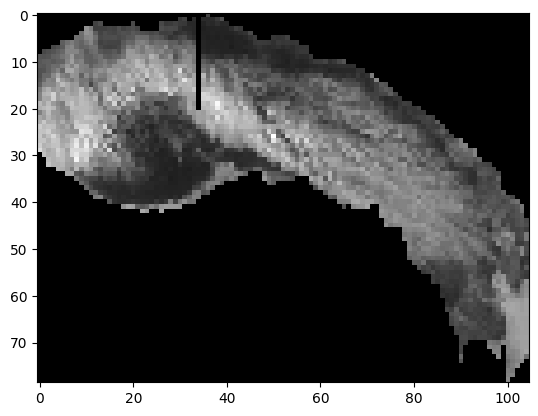

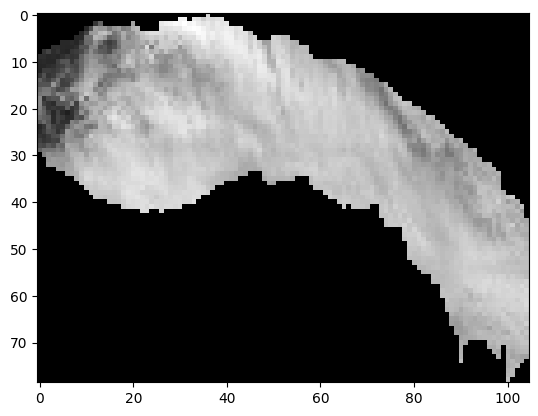

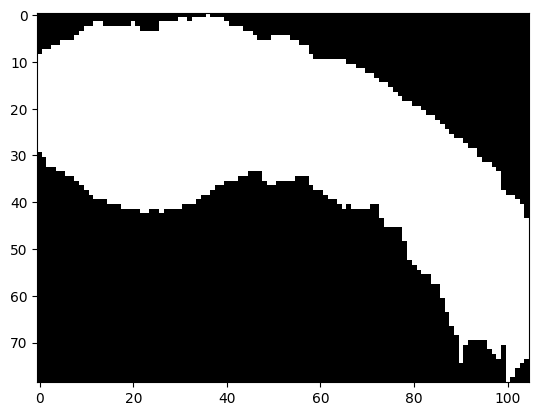

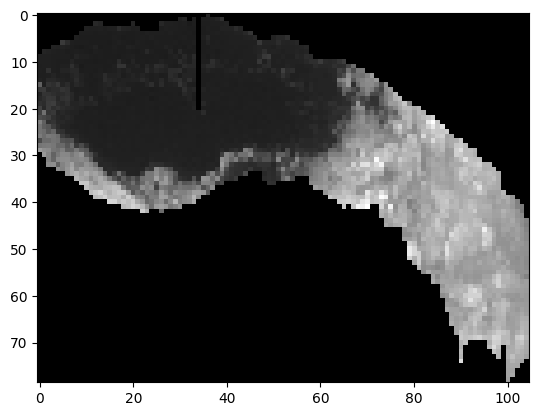

[None, None, None, None, None, None, None, None, None, None]

In [16]:
#%%
#Ensure the file lat_long_1D_labels_for_plotting.csv is in the working directory (DATA_dir)
df_lat_lon = df_lat_lon = pd.read_csv('lat_long_1D_labels_for_plotting.csv')

lat_lst = df_lat_lon['latitude'].to_list()
lat_lst

lon_lst = df_lat_lon['longitude'].to_list()
lon_lst

'''
Validating our assumption about the intensity
Important to ensure that the length of
- Latitude
- Longitude 
- Sample 
are the same 
'''
check = data1.copy()
check = check[check['Avg_Intensity_Rounded']>0.3].sample(10)

[plot_pic(np.array(x)) for x in list(check['Lake_data_2D'])]

In [17]:
data1.columns

Index(['Lake_data_2D', 'Snowfall', 'Date_CST_x', 'Time_CST_x', 'Check',
       'Date_Time', 'Date_CST_y', 'Time_CST_y', 'Temp (F)', 'RH (%)',
       'Dewpt (F)', 'Wind Spd (mph)', 'Wind Direction (deg)',
       'Peak Wind Gust(mph)', 'Low Cloud Ht (ft)', 'Med Cloud Ht (ft)',
       'High Cloud Ht (ft)', 'Visibility (mi)', 'Atm Press (hPa)',
       'Sea Lev Press (hPa)', 'Altimeter (hPa)', 'Precip (in)',
       'Wind Chill (F)', 'Avg_Intensity', 'Avg_Intensity_Rounded',
       'Temp_Humidity_F', 'Temp (C)', 'Temp_Humidity_C',
       'Temp_Humidity_C_Mean', 'Temp_diff', 'Pressure_diff',
       'Cloud Ceiling (ft)', 'Visibility (m)', 'Mean_Cloud_Height', 'Mean_RH',
       'Heat Index (F)'],
      dtype='object')

## Rewriting converted images and resizing to 64 x 64 
The images are pretty large and take up a lot of memory and processing time for the network, so we decided to resize them into 64 x 64 pixels. Then, we convert the images into grayscale and save them for training. We noticed that when the images are individually analysed with the label the neural network failed to learn from the data. Optimising on the size of the data ensured that the intensity was in place but the sizes were optimised.

(105, 79)


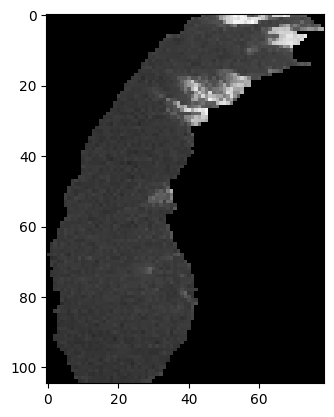

15031
(64, 64)


In [18]:
import skimage.transform as st

#Rotating the image
data1['Lake_data_2D'] = data1['Lake_data_2D'].apply(lambda x : np.rot90(x))

#Converting nested lists to arrays
data1['Lake_data_2D'] = data1['Lake_data_2D'].apply(lambda x : np.array(x))
print((data1['Lake_data_2D'].iloc[0]).shape)

#check the image
plot_pic(data1['Lake_data_2D'].iloc[0])

#Resizing the image
data1['Lake_data_2D'] = data1['Lake_data_2D'].apply(lambda x : st.resize(x, (64, 64)))
data1 = data1.reset_index()
print(len(data1))
print((data1['Lake_data_2D'].iloc[0]).shape)

## Ensuring the arrays are of the right size

In [19]:
data1['Lake_data_2D'] = data1['Lake_data_2D'].apply(lambda x : np.array(x).reshape(x.shape[0],x.shape[1],1))

In [20]:
print("Length of Data Before Shift : ",len(data1))

Length of Data Before Shift :  15031


## Sliding window

We take advantage of `Pandas shift API`- this feature helps us build our data
`shift_data(data1,48)` helps predict the occurence of snowfall 2 days in advance, our model was not performing too well when it was prediciting **72 Hours** in advance. Hence we went to a 48 hour timeline.

In [21]:
data1 = shift_data(data1,48)

Predicting for  48  hours :


In [22]:
print("Length of Data After Shift : ",len(data1))

Length of Data After Shift :  14983


## Removing columns from the main dataset

In [23]:
#Removing all time columns from the dataset
data1 = data1[[x for x in data1.columns if x not in ['Date_CST_x', 'Time_CST_x', 'Check',
       'Date_Time', 'Date_CST_y', 'Time_CST_y','index','New_Lake_2D_data']]]

## Segregating data

The dataset is segregated from the main dataset

`weather_data` - consists of all the data from the weather station
`image_data`   - consists of all the data from the satellite

Both dataframes are ready to be used in the Neural Network

In [24]:
#Taking required column from the main dataset for image data
image_data = data1[['Lake_data_2D','LESShift48']]
image_data.iloc[:,0] = image_data.iloc[:,0].apply(lambda x : np.array(x))

In [25]:
#Taking required column from the main dataset for weather data
weather_data = data1[[x for x in data1.columns if x not in ['Lake_data_2D','Snowfall']]]

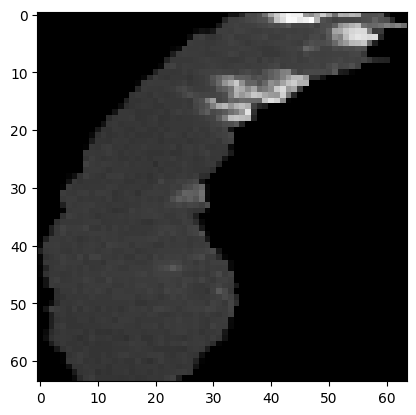

In [26]:
plot_pic(image_data.iloc[0,0])

In [27]:
print("Size of our image ",image_data.iloc[0,0].shape)

Size of our image  (64, 64, 1)


## Data Analysis

- **Considering features which cause snowfall like Temperature and Precipitation were some of the columns considered**

In [28]:
#nr - not required
nr = ['Wind Spd (mph)',
       'Wind Direction (deg)', 'Peak Wind Gust(mph)', 'Low Cloud Ht (ft)',
       'Med Cloud Ht (ft)', 'High Cloud Ht (ft)', 'Visibility (mi)', 'Altimeter (hPa)'
'Temp (C)', 'Temp_Humidity_C', 'Temp_Humidity_C_Mean' 'Temp_diff', 
       'Cloud Ceiling (ft)', 'Visibility (m)','Mean_RH','Altimeter (hPa)','Wind Chill (F)']

#Remove columns which are not required
weather_data = weather_data[[x for x in weather_data.columns if x not in nr]]

- **Check columns which we have taken in our numerical data**

In [29]:
weather_data.columns

Index(['Temp (F)', 'RH (%)', 'Dewpt (F)', 'Atm Press (hPa)',
       'Sea Lev Press (hPa)', 'Precip (in)', 'Avg_Intensity',
       'Avg_Intensity_Rounded', 'Temp_Humidity_F', 'Temp (C)',
       'Temp_Humidity_C_Mean', 'Temp_diff', 'Pressure_diff',
       'Mean_Cloud_Height', 'Heat Index (F)', 'LESShift48'],
      dtype='object')

- **Distribution of the columns of the data**

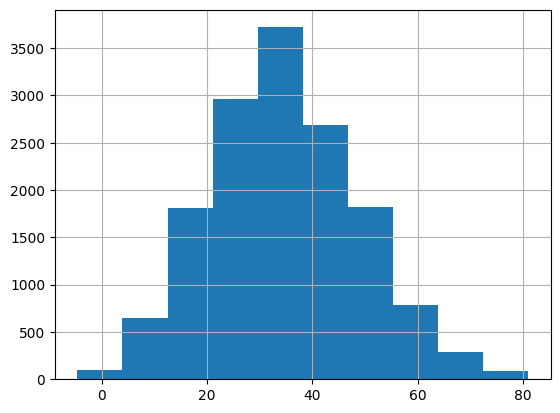

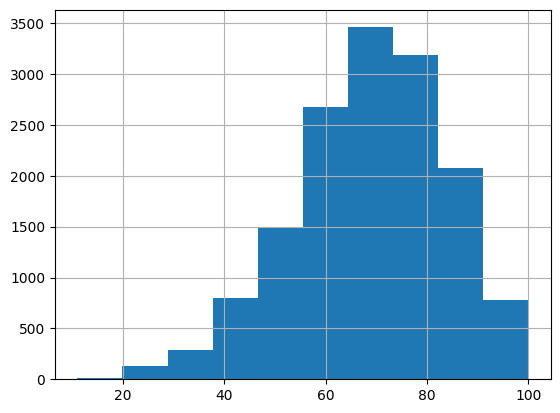

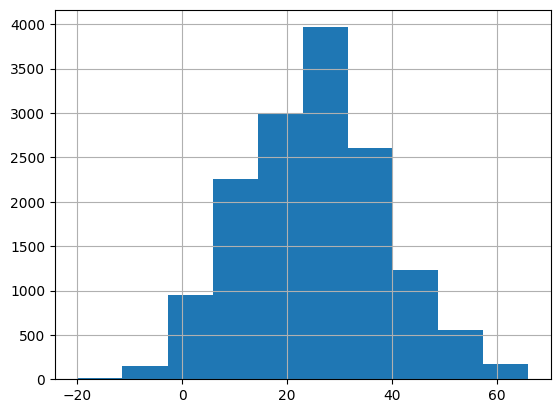

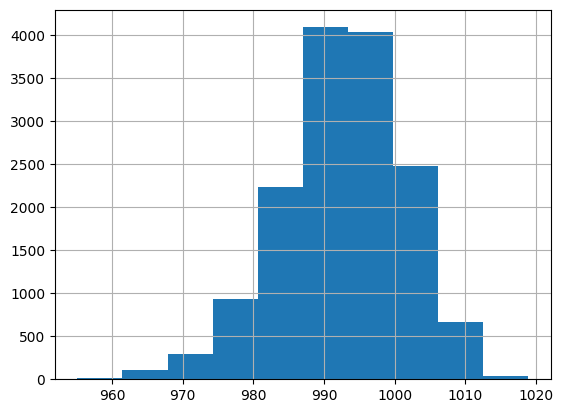

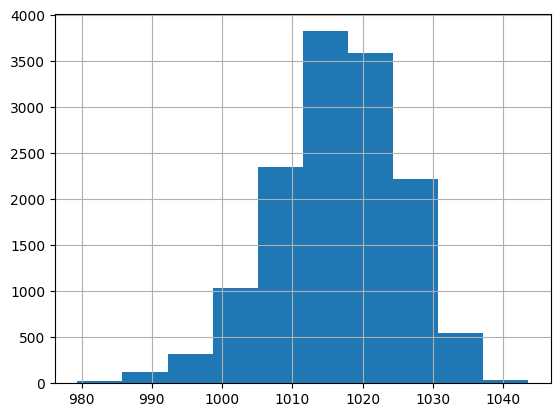

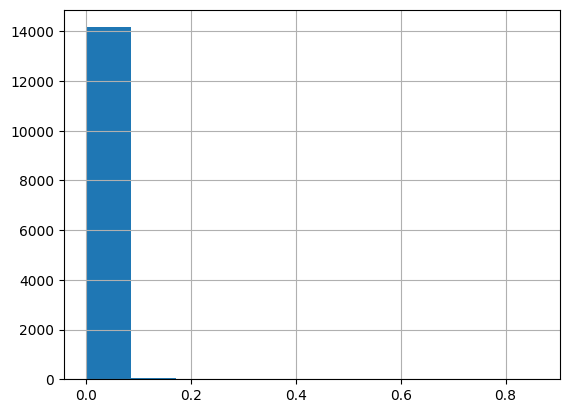

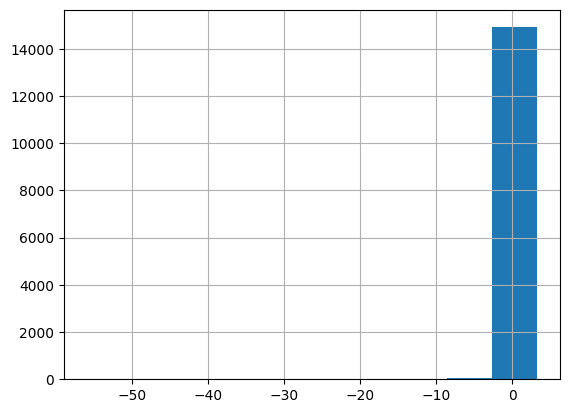

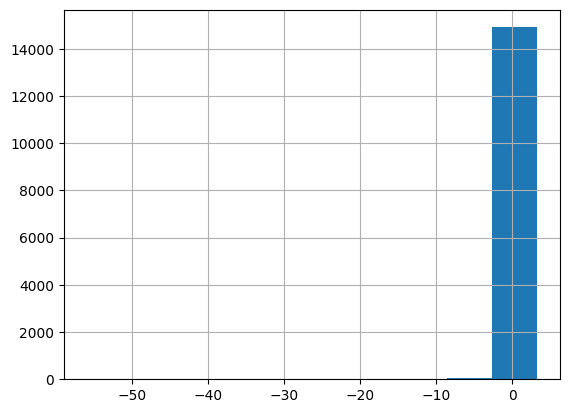

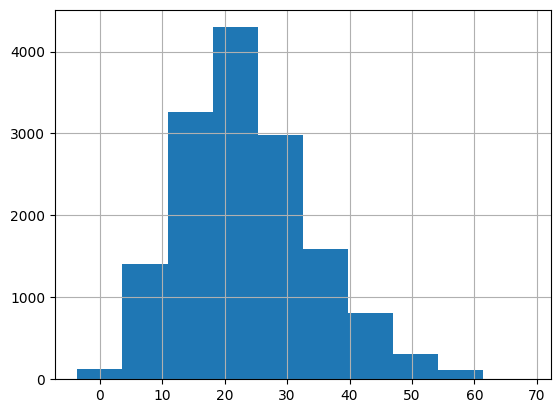

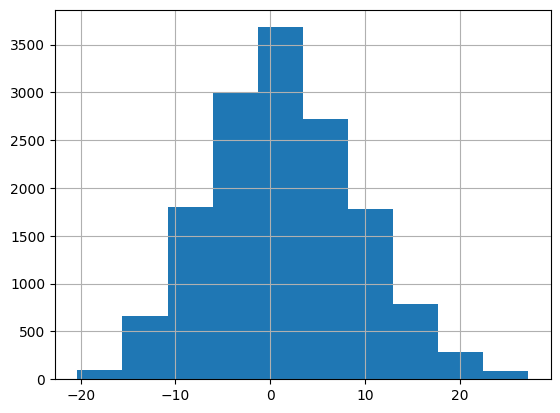

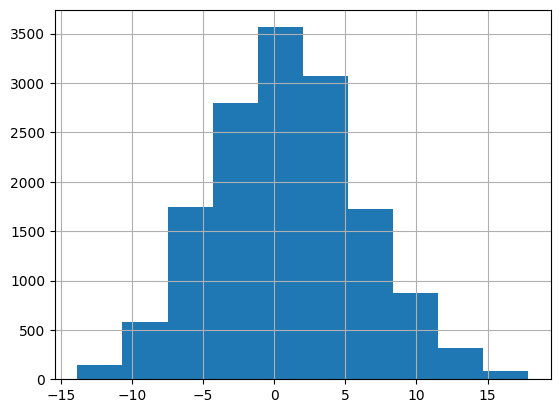

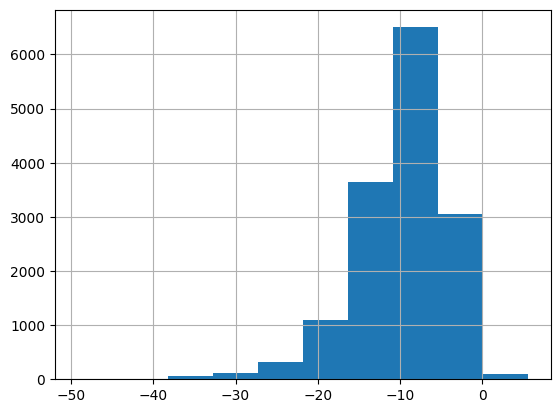

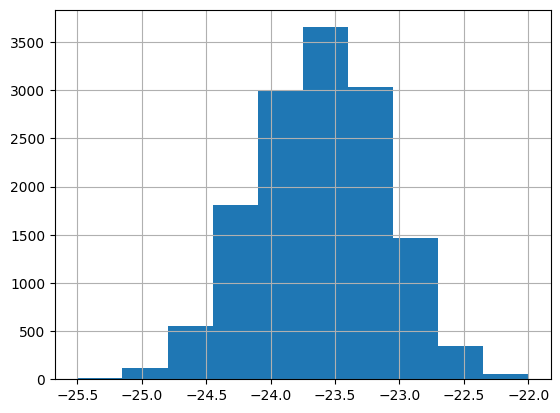

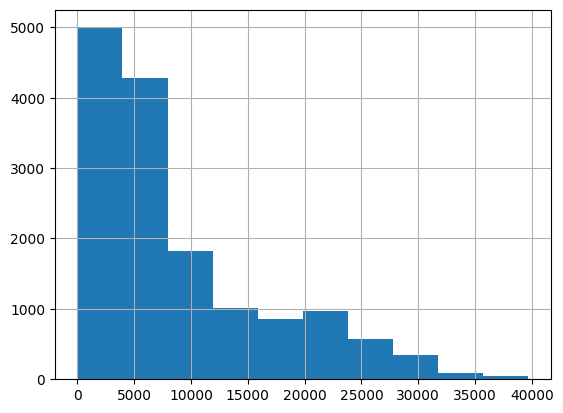

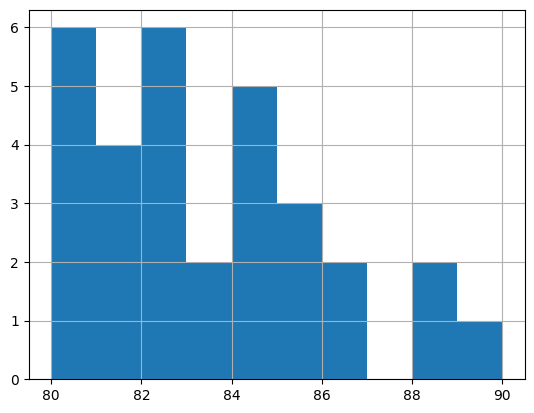

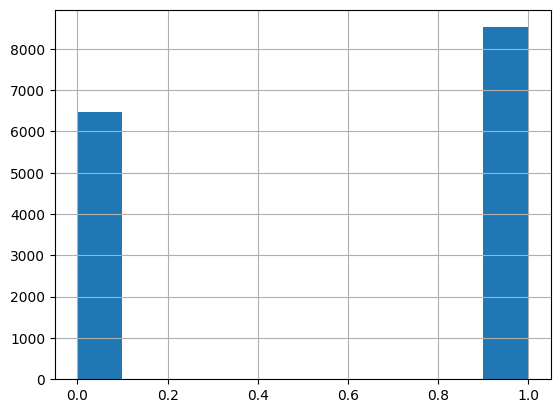

In [30]:
for cols in weather_data.columns:
    weather_data[cols].hist()
    plt.show()

## Forming our Training and Testing Labels

<font color='red'> Dont forget - Normalising The Numerical Data</font>

MinMaxScaler is suitable when the range of the data is important, and StandardScaler is suitable when the shape of the distribution is important. It is important to choose the appropriate normalization technique based on the characteristics of the data and the specific problem you are trying to solve.

We found that using both MinMaxScaler and StandardScaler has different impacts while constructing a neural network.

In [31]:
#Using the Sklearn StandardScaler API for normalising the data
scaler = StandardScaler()

y_weather = weather_data.iloc[:,-1]
X_weather = weather_data.iloc[:,0:-1]
X_weather[np.isnan(X_weather)] = 0  
X_weather = scaler.fit_transform(X_weather)


In [32]:
X_image = np.stack(image_data.iloc[:,0])
y_image = image_data.iloc[:,-1] 

**Crop images to remove extra padding from the image**

In [33]:
#Using the train_test_split API from SKlearn
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_image, y_image, test_size=0.3, random_state=42)

#Reshaping the dataframe to the right shape so that it can be used in the neural network
x_train1 = x_train1.reshape(x_train1.shape[0],x_train1.shape[1], x_train1.shape[2], 1)[:,8:56,8:-8,:]#np.expand_dims(x_train1)
x_test1 = x_test1.reshape(x_test1.shape[0],x_test1.shape[1], x_test1.shape[2], 1)[:,8:56,8:-8,:]#np.ex

x_train2, x_test2, y_train2, y_test2 = train_test_split(X_weather, y_weather, test_size=0.3, random_state=42)

- `x_train1`- Training data for images
- `x_test1` - Testing/Validating data for images

- `x_train2`- Training data for weather
- `x_test2` - Testing/Validating data for weather

- `y_train1` & `y_train2` - Training labels
- `y_test1`  & `y_test2`  - Testing labels



In [34]:
print("Training Data Size Images: ",x_train1.shape, " & Weather ",x_train2.shape)  
print("Training Labels Size Images:  ",y_train1.shape, " & Weather ",y_train2.shape)  
print("Testing Data Size Images:  ",x_test1.shape, " & Weather ",x_test2.shape)  
print("Testing Labels Size Images:  ",y_test1.shape, " & Weather ",y_test2.shape)  

Training Data Size Images:  (10488, 48, 48, 1)  & Weather  (10488, 15)
Training Labels Size Images:   (10488,)  & Weather  (10488,)
Testing Data Size Images:   (4495, 48, 48, 1)  & Weather  (4495, 15)
Testing Labels Size Images:   (4495,)  & Weather  (4495,)


## Building our Neural Network using this dataset

The following techniques were experimented with to come up with  a Neural network to predict the occurence of snowfall.

- **Analysing Individual images using a CNN**
- **Analysing the Numerical data using an RNN**
- **Analysing Yearly data individually using a combination of CNN and RNN**
- **Transfer Learning to improve models Year over Year**
- **Analysing all 10 years as a single dataset**

### The conclusions drawn from the above techniques were

- Analysing Individual images helped us come up with the fact that images needed reshaping and the default shape did not yield **our team** good results
- Analysing Numerical data aided in coming up with an optimum LSTM network 
- When using individual years data we found that the learning rates were different and that it played an important parameter in our network
- Transfer learning was a fun methodology which involved analysing each years data individually and then optimising the model of the following year with the wieights of the previous years model. 


### From the above techniques we were able to come up with an optimised Neural Network structure

- Finally we found that the dataset got decent results only when all 10 years were used in the model.

**Given Below is an optimised architecture of the Neural Network used for the dataset used in this notebook**

## Model Architecture

**About the CNN**

The CNN uses an input layer and 2 different layers of `six neurons` each - we tried using higher number of neurons which lead to overfitting. The kernel size consists of `(3,3)`. 

An additional dropout layer is used which helps in randomly setting input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.

`GlobalAveragePooling2D` is another method which is used to replace Flatten in the network. We used this as most of our networks were overfitting.

`ReLU` is a simple and efficient activation function that is commonly used in deep learning, but it can lead to dead neurons. `SELU` is a self-normalizing activation function that can help address the vanishing gradient problem and prevent dead neurons, and it can lead to better convergence and generalization performance.

**About the RNN**

The RNN uses an input layer and 2 `LSTM` layers of 6 neurons each. The input data which in this case consists of our weather data is fed into this network. The activation function used is a `tanh`.

A dropout layer is also added here. The presence of dropout layers is because of the pattern in losses observed when this layer was not used. The model didnot learn well till this layer was introduced

Each layer of the RNN has a mention of `return_sequence` this helps the model learn better once the neurons start seeing the data

**Combining Both Models**

Both the Networks are combined with a `relu` activation function. the output activation function is a `sigmoid` this is because of the fact that the labels are either `0` or `1`. A `softmax` was tried but we noticed that it gave us a constant accuracy. 

**About the final model**
- `Learning Rate` - 0.01
- `optimiser` - Adam
- `Loss Function` - binary_crossentropy
- `Metrics` - Accuracy(training and validation), precision, F1, Recall

In [35]:
try:
    #Delete an older model if it exists
    del model
except:
    pass

#Shape of the image getting analysed and the CNN neurons
#MaxPooling2D layer helps in extracting the most salient features from the input 
#GlobalAveragePooling2D is used instead of flatten to reduce the number of features
input_cnn = Input(shape=(48,48,1))
cnn_layer = Conv2D(filters=6, kernel_size=(3,3), activation='relu', padding='same')(input_cnn)
cnn_layer = MaxPooling2D(pool_size=(2,2))(cnn_layer)
cnn_layer = Conv2D(filters=6, kernel_size=(3,3), activation='relu', padding='same')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size=(2,2))(cnn_layer)
cnn_layer = Conv2D(filters=6, kernel_size=(3,3), activation='relu', padding='same')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size=(2,2))(cnn_layer)
cnn_layer = tf.keras.layers.GlobalAveragePooling2D()(cnn_layer)
cnn_layer = Dropout(0.25)(cnn_layer)
cnn_model = Model(inputs=input_cnn, outputs=cnn_layer)

#Shape of the input data for the RNN and the RNN neurons
input_rnn = Input(shape=(x_train2[0].shape[0],))
rnn_layer = Dense(64, activation='tanh')(input_rnn)
rnn_layer = tf.keras.layers.Reshape((1,64))(rnn_layer)
rnn_layer = LSTM(6, return_sequences=True)(rnn_layer)
rnn_layer = LSTM(6, return_sequences=False)(rnn_layer)
rnn_layer = Dropout(0.5)(rnn_layer)
rnn_model = Model(inputs=input_rnn, outputs=rnn_layer)

#Combining all the above models
combined_layer = tf.keras.layers.concatenate([cnn_model.output, rnn_model.output])
combined_layer = Dense(6, activation='relu')(combined_layer)
output_layer = Dense(1, activation='sigmoid')(combined_layer)
model = Model(inputs=[cnn_model.input, rnn_model.input], outputs=output_layer)

#Visualise the model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 6)    60          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 24, 6)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 24, 6)    330         ['max_pooling2d[0][0]']          
                                                                                            

## Fitting the model on the training dataset

In [36]:
#Parameters of the model
learning_rate = 0.01
opt = 'adam'

#Metrics to showcase during the analysis of the model
metrics=['accuracy',f1_m,precision_m, recall_m]
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)

#Explicitly mentioning the learning rate
model.optimizer.get_config()['learning_rate'] = learning_rate

#Monitor loss to ensure that loss doesnt increase
# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit([x_train1, x_train2], y_train1, epochs=15,validation_split=0.30, batch_size=16, validation_data=([x_test1, x_test2], y_test1)
                   ,callbacks=None)


Epoch 1/15
656/656 [==============================] - 36s 33ms/step - loss: 0.6843 - accuracy: 0.5665 - f1_m: 0.7093 - precision_m: 0.5686 - recall_m: 0.9820 - val_loss: 0.6794 - val_accuracy: 0.5695 - val_f1_m: 0.7172 - val_precision_m: 0.5694 - val_recall_m: 1.0000
Epoch 2/15
656/656 [==============================] - 21s 33ms/step - loss: 0.6793 - accuracy: 0.5789 - f1_m: 0.7122 - precision_m: 0.5770 - recall_m: 0.9617 - val_loss: 0.6752 - val_accuracy: 0.5920 - val_f1_m: 0.7173 - val_precision_m: 0.5880 - val_recall_m: 0.9507
Epoch 3/15
656/656 [==============================] - 20s 31ms/step - loss: 0.6752 - accuracy: 0.5908 - f1_m: 0.7055 - precision_m: 0.5921 - recall_m: 0.9003 - val_loss: 0.6720 - val_accuracy: 0.6002 - val_f1_m: 0.7019 - val_precision_m: 0.6031 - val_recall_m: 0.8694
Epoch 4/15
656/656 [==============================] - 21s 32ms/step - loss: 0.6733 - accuracy: 0.5995 - f1_m: 0.7087 - precision_m: 0.5985 - recall_m: 0.8976 - val_loss: 0.6698 - val_accuracy: 0.5

## Reviewing the overall Metrics

- Our model converged early just after 15 epochs  - we noticed that there was massive overfitting after a certain number of epochs

- Analysing the Loss on validation and training data

- Analysing the accuracy on validation and training data

- Output of prediction on our test dataset and its respective losses

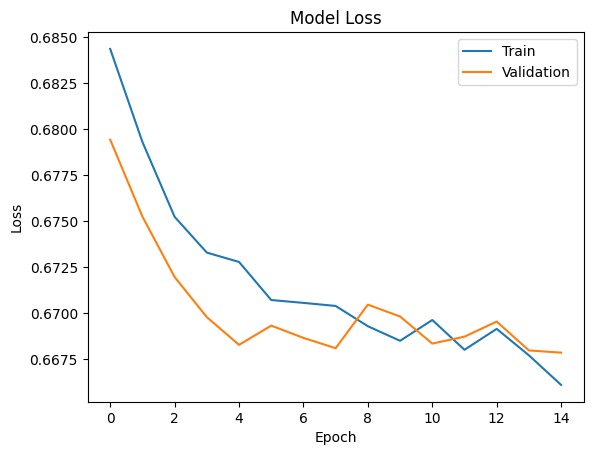

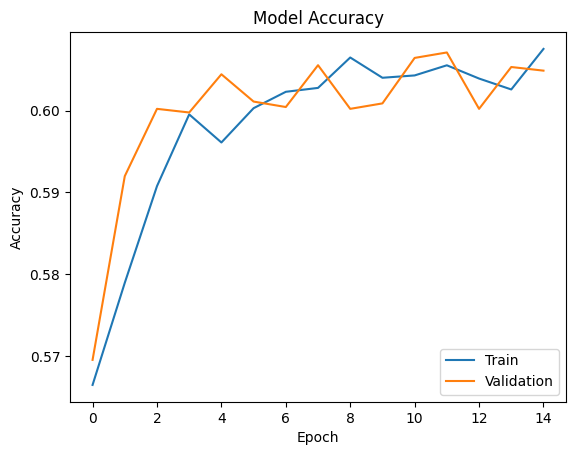

In [37]:
#Accuracy and loss of the model
model_metrics(history)

In [38]:
#Printing the predicted labels
print(np.round(model.predict([x_test1, x_test2])))

141/141 [==============================] - 5s 15ms/step
[[1.]
 [0.]
 [1.]
 ...
 [1.]
 [0.]
 [1.]]


In [39]:
# Prediction using X_test
pred = np.round(model.predict([x_test1, x_test2]))
# Convert to array
pred = np.array(pred)

# Assigning class based on prediction
pred[pred>0.5] = 1
pred[pred<1] = 0

# Class-wise accuracy
classwise1 = ((np.array(pred)[:,0] == np.array(y_test1))*(y_test1==1)).sum()/(y_test1==1).sum()
classwise0 = ((np.array(pred)[:,0] == np.array(y_test1))*(y_test1==0)).sum()/(y_test1==0).sum()

print(f'Total Accuracy: {((np.array(pred)[:,0] == np.array(y_test1)).sum()/len(pred))*100:.0f}')

141/141 [==============================] - 3s 19ms/step
Total Accuracy: 60


# Conclusion


From the above metrics we can see that our Neural Network has had **some** improvement over our base model but there is **scope for improving** its overall accuracy. The **training loss is decreasing** significantly along with the **validating loss**, the model converges early and achieves an overall accuracy of **60 %**.

Some of the key takeaways from this model which can help us build a better model are. 

1. With respect to the data

- Data Balancing technique - The approach taken to try to balance the data may need improvement

- Feature extraction to ensure the right features are taken and the wrong ones are implemented

- Manipulating the dimensions of the dataset to ensure more features are present for the model to make better decisions



2. With respect to the model


- Layers - The number of layers can be increased to facilitate the large quantities of data

- Neurons - When dealing with images neurons with power 2 can be considered.

- regularization - This can help in preventing overfitting

- Early Stopping - Passing this parameter to the model can help in stopping the model from overshooting while managing the validation loss. 

Some of the Above techniques have been used in building a much better performing model.

## References

References 1. : https://sciencing.com/conditions-necessary-snow-7457372.html

References 2  : https://nsidc.org/learn/parts-cryosphere/snow/science-snow   

References 3  : https://stackoverflow.com/questions/49295311/what-is-the-difference-between-flatten-and-globalaveragepooling2d-in-keras   

In [40]:
elapsed = timeit.default_timer() - start_time
print("############## TOTAL TIME TAKEN : ", elapsed) 

############## TOTAL TIME TAKEN :  437.5575969
